In [1]:
import matplotlib
from config import tiny_image_net_config as config
from hdf5.hdf5datasetgenerator import HDF5DatasetGenerator
from model.RestNet50 import ResNet
from model.training_monitor import TrainingMonitor
from keras_preprocessing.image import ImageDataGenerator
import tensorflow as tf
from pathlib import Path
import os

matplotlib.use("Agg")

aug = ImageDataGenerator(rotation_range=20, zoom_range=0.15,
                         width_shift_range=0.2, height_shift_range=0.2,
                         shear_range=0.15, horizontal_flip=True, fill_mode='nearest')

trainGen = HDF5DatasetGenerator(config.TRAIN_HDF5, 64, aug=aug, binarize=False, classes=200, mean=True)
valGen = HDF5DatasetGenerator(config.VAL_HDF5, 64, binarize=False, classes=200, mean=True)

C:\Users\vanou\Anaconda3\lib\site-packages\numpy\core\__init__.py:29: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\vanou\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\vanou\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
  stacklevel=1)
D:\Projects\ML_projects\tiny_imagenet\hdf5\hdf5datasetgenerator.py:23: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  self.db = h5py.File(dbPath)


In [2]:
opt = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
model = ResNet.build(64, 64, 3, 200, (3, 4, 6), (64, 128, 256, 512), reg=0.0005, dataset="tiny_imagenet")

early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=5,
                                              verbose=1, restore_best_weights=True)


tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=config.TENSORBOARD_LOG, histogram_freq=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, min_lr=0.00001, patience=4, verbose=1)

model.compile(loss="sparse_categorical_crossentropy", optimizer=opt,
              metrics=["accuracy"])

In [3]:
start_time = time.time()

history = model.fit_generator(trainGen.generator(),
                              steps_per_epoch=trainGen.numImages // 64,
                              validation_data=valGen.generator(),
                              validation_steps=valGen.numImages // 64,
                              epochs=75,
                              max_queue_size=64*2,
                              callbacks=[tensorboard_callback, reduce_lr, early_stop])

model.save(config.SAVED_MODEL_PATH)
finish_time = time.time()
print("Took time: ", time.strftime("%H:%M:%S", time.gmtime(finish_time - start_time)))

Epoch 1/75
1406/1406 [==============================] - 784s 558ms/step - loss: 5.2875 - accuracy: 0.0530 - val_loss: 5.2203 - val_accuracy: 0.0636
Epoch 2/75
1406/1406 [==============================] - 731s 520ms/step - loss: 4.5920 - accuracy: 0.1218 - val_loss: 4.8868 - val_accuracy: 0.0992
Epoch 3/75
1406/1406 [==============================] - 729s 518ms/step - loss: 4.3056 - accuracy: 0.1635 - val_loss: 4.6379 - val_accuracy: 0.1427
Epoch 4/75
1406/1406 [==============================] - 728s 518ms/step - loss: 4.1405 - accuracy: 0.1940 - val_loss: 4.4209 - val_accuracy: 0.1672
Epoch 5/75
1406/1406 [==============================] - 730s 519ms/step - loss: 4.0354 - accuracy: 0.2175 - val_loss: 4.6490 - val_accuracy: 0.1551
Epoch 6/75
1406/1406 [==============================] - 733s 521ms/step - loss: 3.9656 - accuracy: 0.2376 - val_loss: 4.2917 - val_accuracy: 0.2010
Epoch 7/75
1406/1406 [==============================] - 729s 518ms/step - loss: 3.9180 - accuracy: 0.2524 - val_

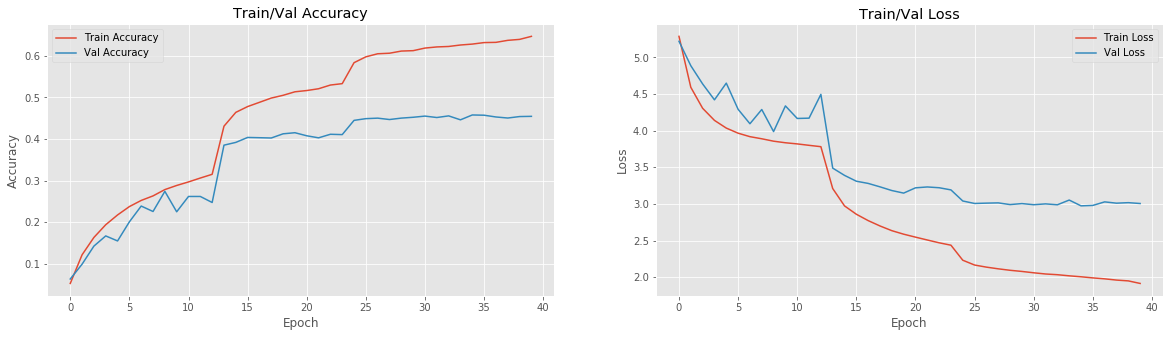

In [4]:
import matplotlib.pyplot as plt
import pandas as pd

plt.style.use("ggplot")
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

f = plt.figure(figsize=(20, 5))
ax1 = f.add_subplot(1, 2, 1)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_title('Train/Val Accuracy')
ax1.plot(hist['epoch'], hist['accuracy'], label='Train Accuracy')
ax1.plot(hist['epoch'], hist['val_accuracy'], label='Val Accuracy')
ax1.legend()

ax2 = f.add_subplot(1, 2, 2)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_title('Train/Val Loss')
ax2.plot(hist['epoch'], hist['loss'], label='Train Loss')
ax2.plot(hist['epoch'], hist['val_loss'], label='Val Loss')
ax2.legend()
plt.show()

In [5]:
testGen = HDF5DatasetGenerator(config.TEST_HDF5, 64, binarize=False, classes=200, mean=True)
score = model.evaluate_generator(testGen.generator(), steps=testGen.numImages // 64, max_queue_size=64 * 2)

loss, acc = score
print("Loss = ", loss)
print("Accuracy = {:.2f}%".format(acc * 100))
testGen.close()

D:\Projects\ML_projects\tiny_imagenet\hdf5\hdf5datasetgenerator.py:23: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  self.db = h5py.File(dbPath)


Loss =  2.9874142790452027
Accuracy = 46.18%
